In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import geopandas as gpd
from fiona.drvsupport import supported_drivers

In [2]:
supported_drivers['KML'] = 'rw'

dubai_area_coordinates = gpd.read_file('Community.kml', driver='KML')

In [3]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [4]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Registration type", "Is Free Hold?", "Master Project"])
    # Drop leaky columns
    data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [5]:
df = drop_excess_columns(df)

In [6]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=6ojuXIi3c32ADoduSeFTjHLA0xnR6eXyR89j7z4RAvaU2wRLFQjriB9SIi7TZnd%2F&ohlc=0')
    
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
    oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

    return oil_data[['date', 'Oil Price']]
    

In [7]:
oil_data = get_oil_price()
oil_data

,date,Oil Price
854,2021-03-01T00:00:00,60.64
855,2021-03-02T00:00:00,59.75
856,2021-03-03T00:00:00,61.28
857,2021-03-04T00:00:00,63.83
858,2021-03-05T00:00:00,66.09
...,...,...
1090,2022-01-28T00:00:00,85.43
1091,2022-01-31T00:00:00,86.49
1092,2022-02-01T00:00:00,86.46
1093,2022-02-02T00:00:00,86.69


In [8]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [9]:
df = drop_period_after_war(df)

In [10]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [11]:
df = merge_oil_to_data(df, oil_data)

In [12]:
def find_length_from_cost(dubai_area_coordinates, point, data_area_name):
    cost = {'y': 25.732457, 'x': 55.090145}
    
    point_locations = dubai_area_coordinates[dubai_area_coordinates['geometry'].contains(point)]
    
    if point_locations.shape[0]:
        return {
            'data_area_name': data_area_name,
            'length_from_coast': ((point.x-cost['x'])**2+(point.y-cost['y'])**2)**(1/2)
        }
        
    return None

def add_distance_from_coast_online(data, dubai_area_coordinates):
    areas = data['Area'].unique()
    merged_list = []

    for i in areas:
        point = gpd.tools.geocode(i).loc[0]['geometry']
        
        point_location_object = find_length_from_cost(dubai_area_coordinates, point, i)
        if point_location_object:
            merged_list = merged_list + [point_location_object]
        else:
            point = gpd.tools.geocode('Dubai ' + i).loc[0]['geometry']
            point_location_object = find_length_from_cost(dubai_area_coordinates, point, i)
            if point_location_object:
                merged_list = merged_list + [point_location_object]
    
    lenghts_from_cost = pd.DataFrame(merged_list)
    
    lenghts_from_cost.to_csv('length_from_coast.csv')
    
    data = data.merge(lenghts_from_cost, left_on='Area', right_on='data_area_name')
    
    return data
    

In [13]:
def add_distance_from_coast_from_file(data):
    lenghts_from_cost = pd.read_csv('length_from_coast.csv')
    data = data.merge(lenghts_from_cost, left_on='Area', right_on='data_area_name')
    
    return data

In [14]:
# add_distance_from_coast_online(df, dubai_area_coordinates)
df = add_distance_from_coast_from_file(df)

In [15]:
def change_variables_essence(data):
    data['Nearest Metro'] = data['Nearest Metro'].apply(lambda m: 1 if m else 0)
    data['Nearest Mall'] = data['Nearest Mall'].apply(lambda m: 1 if m else 0)  
    return data

In [16]:
df = change_variables_essence(df)

In [17]:
df

,Transaction Date,Transaction Type,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,Nearest Mall,Nearest Landmark,date_without_time,date,Oil Price,Unnamed: 0,data_area_name,length_from_coast
0,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1.435909e+06,138.93,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
1,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1.435909e+06,87.26,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
2,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1.435909e+06,76.13,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
3,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1.435909e+06,130.05,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
4,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1.435909e+06,52.15,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67129,2021-05-27 10:31:16,Gifts,Commercial,Al Rega,Commercial,4.700000e+07,725.02,1,1,Dubai International Airport,2021-05-27,2021-05-27T00:00:00,66.60,213,Al Rega,0.534146
67130,2021-05-27 10:44:02,Gifts,Commercial,Al Rega,Commercial,4.000000e+07,606.19,1,1,Dubai International Airport,2021-05-27,2021-05-27T00:00:00,66.60,213,Al Rega,0.534146
67131,2021-06-02 10:24:27,Gifts,Commercial,Al Rega,Commercial,5.000000e+07,1139.64,1,1,Dubai International Airport,2021-06-02,2021-06-02T00:00:00,68.63,213,Al Rega,0.534146
67132,2021-05-24 11:39:40,Gifts,Commercial,Al Buteen,Commercial,9.500000e+07,724.64,1,1,Dubai International Airport,2021-05-24,2021-05-24T00:00:00,65.78,214,Al Buteen,0.527464


In [18]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.98)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    data = data.dropna()
    return data

In [19]:
cleaned_df = clean_outliers_in_data(df)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_73454/708482841.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.98)


In [20]:
cleaned_df

,Transaction Date,Transaction Type,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,Nearest Mall,Nearest Landmark,date_without_time,date,Oil Price,Unnamed: 0,data_area_name,length_from_coast
0,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,138.93,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
1,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,87.26,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
2,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,76.13,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
3,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,130.05,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
4,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,52.15,1,1,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67082,2021-05-31 14:59:25,Sales,Commercial,Al Qusais Industrial Fourth,Commercial,9500000.00,1302.87,1,1,Dubai International Airport,2021-05-31,2021-05-31T00:00:00,66.93,193,Al Qusais Industrial Fourth,0.537750
67108,2021-04-07 13:02:45,Sales,Residential,Al Saffa First,Residential,6800000.00,1525.93,1,1,Downtown Dubai,2021-04-07,2021-04-07T00:00:00,59.77,204,Al Saffa First,0.660583
67109,2021-04-26 11:55:45,Sales,Residential,Al Saffa First,Residential,2800000.00,1393.55,1,1,Downtown Dubai,2021-04-26,2021-04-26T00:00:00,61.91,204,Al Saffa First,0.660583
67110,2021-05-17 10:10:56,Sales,Residential,Al Saffa First,Residential,5000000.00,1393.55,1,1,Downtown Dubai,2021-05-17,2021-05-17T00:00:00,66.27,204,Al Saffa First,0.660583


In [21]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

count    54024.000000
mean       189.573554
std        221.506437
min          7.300000
25%         72.040000
50%        118.390000
75%        199.830000
max       1713.510000
Name: Property Size (sq.m), dtype: float64

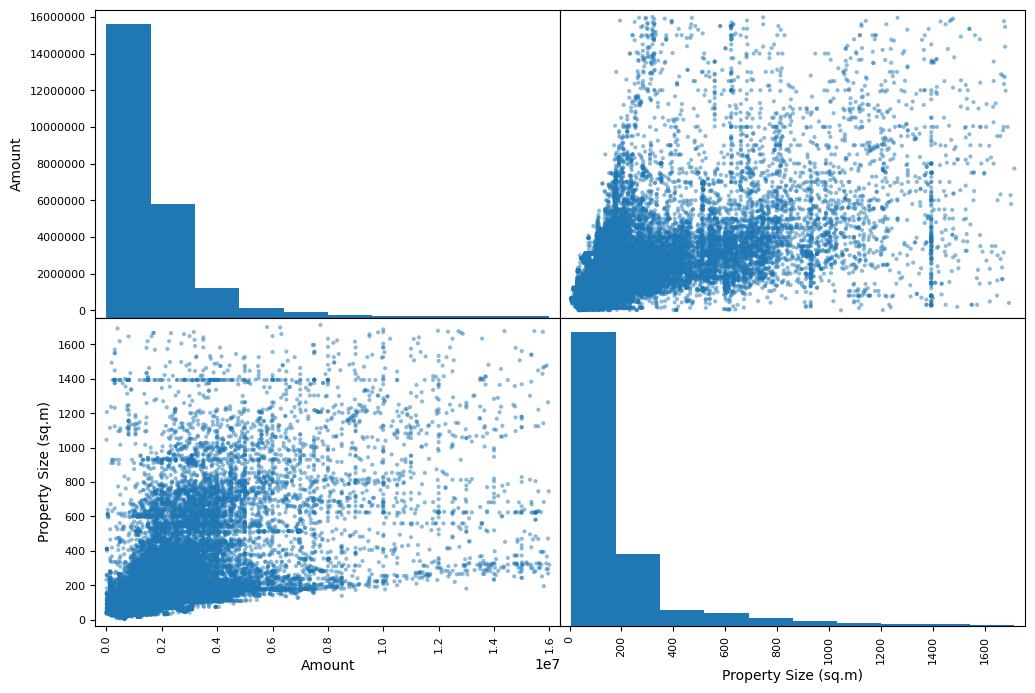

In [22]:
plot_matrix(cleaned_df)

In [23]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [24]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
        'length_from_coast': 'Length_From_Coast'
    }
)

In [ ]:
import statsmodels.formula.api as smf

sm_data = sm.add_constant(prepared_data)
first_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark)', data=sm_data)
first_results = first_model.fit()


In [ ]:
first_results.summary()

In [ ]:
sm_data = sm.add_constant(prepared_data)
second_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast', data=sm_data)
second_results = second_model.fit()


In [ ]:
second_results.summary()

In [ ]:
pred_ols = second_results.get_prediction()

fig, ax = plt.subplots(figsize=(8, 6))

x = prepared_data['Property_Size']
y = prepared_data['Amount']

ax.plot(x, y, "o", label="data")
ax.plot(x, second_results.fittedvalues, "o", label="OLS")

ax.legend(loc="best")

In [ ]:
prepared_data['Property_Size_Squared'] = prepared_data['Property_Size']**2

In [ ]:
sm_data = sm.add_constant(prepared_data)
third_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + Property_Size_Squared + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast', data=sm_data)
third_results = third_model.fit()


In [ ]:
second_results.summary()